In [1]:
ANCHOR_CONST = 0
POSITIVE_CONST = 1
LABEL_CONST = 2

In [50]:
import preprocessing as pp
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow_datasets as tfds
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
ANC_PATH = "/Users/julietastaryfurmanshalom/OneDrive/ITC/Face_Rec/data/anchor"
POS_PATH = "/Users/julietastaryfurmanshalom/OneDrive/ITC/Face_Rec/data/positive"
NEG_PATH = "/Users/julietastaryfurmanshalom/OneDrive/ITC/Face_Rec/data/negative"

In [8]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(100)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(100)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(100)

2022-01-17 20:18:13.501403: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
data = pp.create_dataset(anchor, positive, negative)
train, test = pp.split_train_test(data, 0.8, batch_size=1)

In [10]:
train = tfds.as_numpy(train)
test = tfds.as_numpy(test)

In [11]:
def flatten_rows(column):
    """
    This function flattens and deletes the color channel of each sample.
    :param column: column to process
    :return: column processed as a list
    """
    result = []
    for element in column:
        flat = element[0].flatten()
        aux_list = []
        for i,f in enumerate(flat):
            if i%3 == 0:
                aux_list.append(f)
        result.append(aux_list)
    return result

In [20]:
def tf_to_pd_dataframe(df):
    """
    This function flattens and deletes the color channel of each sample.
    :param column: column to process
    :return: column processed as a list
    """
        
    # first we create an auxiliar list with all the information from the tf dataset
    aux_list = []
    for i,element in enumerate(df):
        aux_list.append(element)
    
    # We separate the data between anchor, positive and label
    anchor_column = []
    positive_column = []
    label_column = []
    for element in aux_list:
        anchor_column.append(element[ANCHOR_CONST])
        positive_column.append(element[POSITIVE_CONST])
        label_column.append(element[LABEL_CONST])
        
    # We create the label dataset
    y = np.array(label_column).flatten()
    
    # We create the X dataset
    # First, we create the rows with the positive values and anchor values
    positive_rows = flatten_rows(positive_column) 
    anchor_rows = flatten_rows(anchor_column) 
    
    # Now we merge them
    final_row = []
    for a,p in zip(anchor_rows,positive_rows):
        final_row.append(a+p)
        
    X_train = pd.DataFrame(final_row)
    
    return(X_train,y)

In [21]:
X_train, y_train = tf_to_pd_dataframe(train)
X_test, y_test = tf_to_pd_dataframe(test)

### Let's check if the data is balanced

**TRAIN SET**

In [43]:
pd.DataFrame(y_train).value_counts() / y_train.shape[0]

1.0    0.51875
0.0    0.48125
dtype: float64

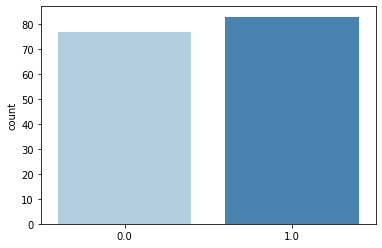

In [51]:
sns.countplot(y_train,palette='Blues');

**TEST SET**

In [53]:
pd.DataFrame(y_test).value_counts() / y_test.shape[0]

1.0    0.55
0.0    0.45
dtype: float64

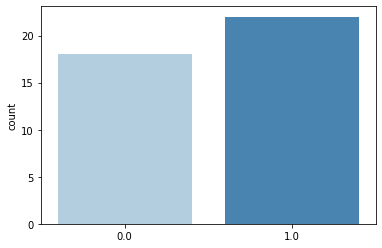

In [54]:
sns.countplot(y_test,palette='Blues');

The data is balanced, if we do a baseline model where all the samples are predicted as 1,the accuracy would be 55%. 

## BASELINE MODEL

In [55]:
clf = BernoulliNB(binarize=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [56]:
accuracy_score(y_test,y_pred)

0.7

The accuracy is better than the random guess